In [ ]:
import time

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from functools import partial
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import (Input, Conv2D, Dense, MaxPool2D, Flatten, 
                                     GlobalAveragePooling2D, Add, Activation,
                                     BatchNormalization, ZeroPadding2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data load and pre-processing

In [ ]:
train_ds, info = tfds.load("stanford_dogs",
                           split="train[:80%]",
                           as_supervised=True,
                           shuffle_files=True,
                           with_info=True)

val_ds = tfds.load("stanford_dogs",
                    split="train[80%:]",
                    as_supervised=True,
                    shuffle_files=True,)

test_ds = tfds.load("stanford_dogs",
                    split="test",
                    as_supervised=True,
                    shuffle_files=True,)

Min and max pixel values : (0, 255)
Image's shape : (500, 333, 3)


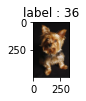

Min and max pixel values : (0, 255)
Image's shape : (333, 500, 3)


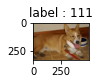

Min and max pixel values : (0, 255)
Image's shape : (380, 500, 3)


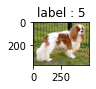

Min and max pixel values : (0, 255)
Image's shape : (310, 401, 3)


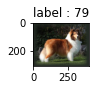

In [ ]:
for img, label in train_ds.take(4):
    plt.figure(figsize=(1,1))
    plt.title(f"label : {label}")
    plt.imshow(img)
    print(f"Min and max pixel values : {img.numpy().min(), img.numpy().max()}")
    print(f"Image's shape : {img.shape}")
    plt.show()

### Hyperprameter

In [ ]:
TRAIN_SIZE = info.splits['train'].num_examples
IMAGE_SIZE = 224
BATCH_SIZE = 128
BUFFER_SIZE = int(TRAIN_SIZE)
NUM_CLASSES = 120
EPOCHS = 30
AUTOTUNE = tf.data.experimental.AUTOTUNE

#### Data 전처리 및 augmentaiton 하기

In [ ]:
def preprocessing(img, label, image_size):
    """(m, n) image size -> (224, 224)"""
    # img = tf.cast(img, tf.float32) / 255.
    return tf.image.resize(img, (image_size, image_size)), label

In [ ]:
train_data = train_ds.map(partial(preprocessing, image_size=IMAGE_SIZE),
                          num_parallel_calls=AUTOTUNE)
val_data = val_ds.map(partial(preprocessing, image_size=IMAGE_SIZE),
                        num_parallel_calls=AUTOTUNE)
test_data = test_ds.map(partial(preprocessing, image_size=IMAGE_SIZE),
                        num_parallel_calls=AUTOTUNE)

### Build model

In [ ]:
train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
def vis(data):
    tmp = data.take(1)
    tmp = next(iter(tmp))
    print(tmp[0].shape)

    fig = plt.figure(figsize=(10, 10))
    for i in range(9):
        img = tmp[0][i]
        label = tmp[1][i].numpy()
        ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
        ax.imshow(img.numpy().astype("int64"))
        ax.set_title(f"Label: {label}, Size: {img.shape}")

(128, 224, 224, 3)


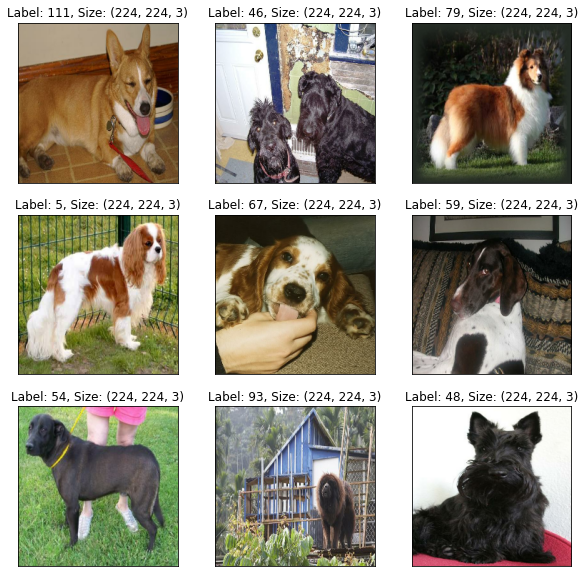

In [ ]:
vis(train_data)

### Transfer learning

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

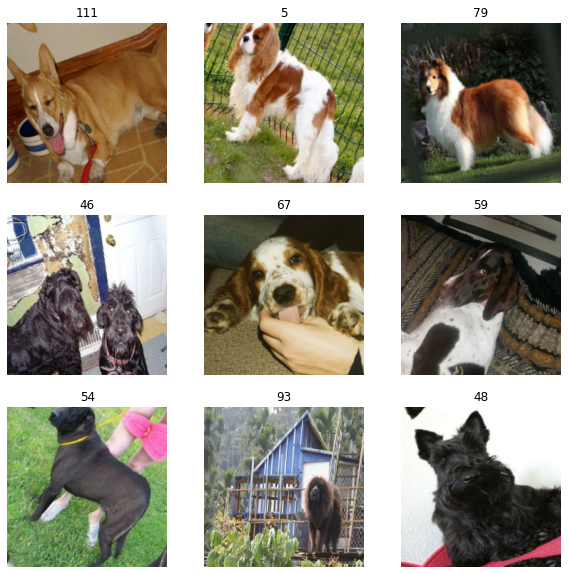

In [ ]:
for img, labels in train_data.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        aug_img = data_augmentation(
            tf.expand_dims(img[i], 0), training=True
        )
        plt.imshow(aug_img[0].numpy().astype("int64"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB3, VGG19
from keras import metrics

BACKBONE = VGG19
def build_model(BACKBONE, num_classes, use_weight):
    img_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    base_model = BACKBONE(include_top=False, input_shape=img_shape, weights="imagenet")

    # Freeze the pretrained weightsd
    if use_weight == True:
        base_model.trainable = False
    elif use_weight == False:
        base_model.trainable = True

    # build model
    inputs = layers.Input(shape=img_shape)
    x = data_augmentation(inputs)

    norm_layer = keras.layers.experimental.preprocessing.Normalization()
    mean = np.array([127.5]*3)
    var = mean**2
    x = norm_layer(x)
    norm_layer.set_weights([mean, var])

    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="SparseCategoricalCrossentropy",
        metrics=['SparseCategoricalAccuracy']
    )
    return model

In [ ]:
model = build_model(BACKBONE, num_classes=NUM_CLASSES, use_weight=True)

hist = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

80142336/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
______________________________________________________________

### Visualizing train result

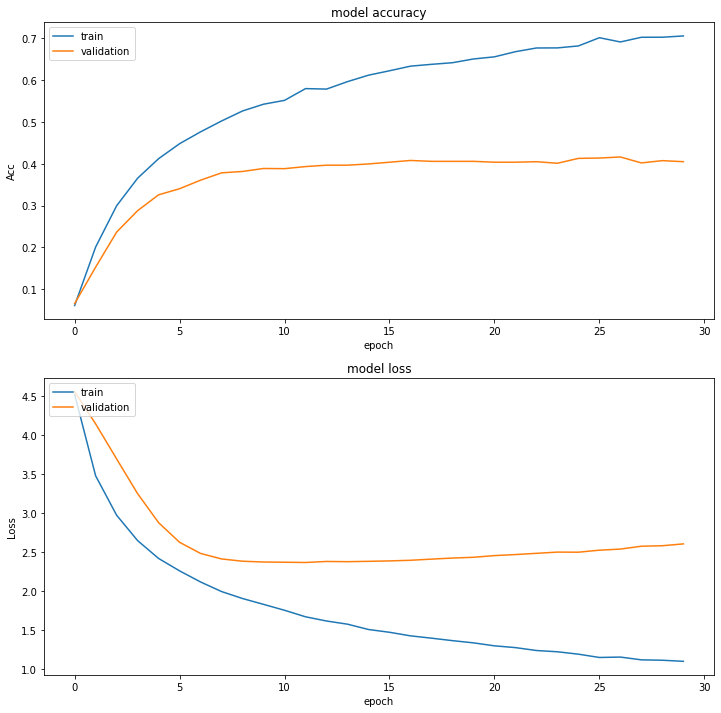

In [ ]:
def plot_hist(hist):
    plt.figure(figsize=(12,12))

    plt.subplot(211)
    plt.plot(hist.history['sparse_categorical_accuracy'])
    plt.plot(hist.history['val_sparse_categorical_accuracy'])
    plt.title("model accuracy")
    plt.xlabel("epoch")
    plt.ylabel("Acc")
    plt.legend(['train','validation'], loc="upper left")

    plt.subplot(212)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("model loss")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend(['train','validation'], loc="upper left")

    plt.show()



plot_hist(hist)

### Model evaluate

In [ ]:
model.evaluate(test_data)

68/68 [==============================] - 44s 647ms/step - loss: 2.5141 - sparse_categorical_accuracy: 0.4212


[2.5141468048095703, 0.4212121069431305]

### ResNet 구현하기

In [ ]:
def identity_block(inp, filters, kernel_size, block, layer):
    
    f1, f2, f3 = filters
    
    conv_name = 'id_conv_b' + block + '_l' + layer
    batch_name = 'id_batch_b' + block + '_l' + layer
    
    x = Conv2D(filters=f1, kernel_size=1, padding='same', kernel_initializer='he_normal', name=conv_name + '_a')(inp)
    x = BatchNormalization(name=batch_name + '_a')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=f2, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name + '_b')(x)
    x = BatchNormalization(name=batch_name + '_b')(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=f3, kernel_size=1, padding='same', kernel_initializer='he_normal', name=conv_name + '_c')(x)
    x = BatchNormalization(name=batch_name + '_c')(x)
    
    add = Add()([inp, x])
    x = Activation('relu')(add)
    
    return x


def convolutional_block(inp, filters, kernel_size, block, layer, strides=2):

    f1, f2, f3 = filters

    conv_name = 'res_conv_b' + block + '_l' + layer
    batch_name = 'res_batch_b' + block + '_l' + layer

    y = Conv2D(filters=f1, kernel_size=1, padding='same', strides=strides, kernel_initializer='he_normal', name=conv_name + '_a')(inp)
    y = BatchNormalization(name=batch_name + '_a')(y)
    y = Activation('relu')(y)

    y = Conv2D(filters=f2, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name + '_b')(y)
    y = BatchNormalization(name=batch_name + '_b')(y)
    y = Activation('relu')(y)

    y = Conv2D(filters=f3, kernel_size=1, padding='same', kernel_initializer='he_normal', name=conv_name + '_c')(y)
    y = BatchNormalization(name=batch_name + '_c')(y)

    shortcut = Conv2D(filters=f3, kernel_size=1, strides=strides, kernel_initializer='he_normal', name=conv_name + '_shortcut')(inp)
    shortcut = BatchNormalization(name=batch_name + '_shortcut')(shortcut)

    add = Add()([shortcut, y])
    y = Activation('relu')(add)

    return y


inp = Input(shape=(224, 224, 3), name='input')
padd = ZeroPadding2D(3)(inp)

conv1 = Conv2D(64, 7, strides=2, padding='valid', name='conv1')(padd)
conv1 = BatchNormalization(name='batch2')(conv1)
conv1 = Activation('relu')(conv1)
conv1 = ZeroPadding2D(1)(conv1)
conv1 = MaxPool2D(3, 2)(conv1)

conv2 = convolutional_block(conv1, [64,64,256], 3, '2', '1', strides=1)
conv2 = identity_block(conv2, [64,64,256], 3, '2', '2')
conv2 = identity_block(conv2, [64,64,256], 3, '2', '3')

conv3 = convolutional_block(conv2, [128,128,512], 3, '3', '1')
conv3 = identity_block(conv3, [128,128,512], 3, '3', '2')
conv3 = identity_block(conv3, [128,128,512], 3, '3', '3')
conv3 = identity_block(conv3, [128,128,512], 3, '3', '4')

conv4 = convolutional_block(conv3, [256,256,1024], 3, '4', '1')
conv4 = identity_block(conv4, [256,256,1024], 3, '4', '2')
conv4 = identity_block(conv4, [256,256,1024], 3, '4', '3')
conv4 = identity_block(conv4, [256,256,1024], 3, '4', '4')
conv4 = identity_block(conv4, [256,256,1024], 3, '4', '5')
conv4 = identity_block(conv4, [256,256,1024], 3, '4', '6')

conv5 = convolutional_block(conv4, [512,512,2048], 3, '5', '1')
conv5 = identity_block(conv5, [512,512,2048], 3, '5', '2')
conv5 = identity_block(conv5, [512,512,2048], 3, '5', '3')

avg_pool = GlobalAveragePooling2D()(conv5)
dense = Dense(NUM_CLASSES, activation='softmax')(avg_pool)

model = Model(inp, dense)

### ResNet 학습

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
        optimizer=optimizer, loss="SparseCategoricalCrossentropy",
        metrics=['SparseCategoricalAccuracy'])
res_history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

In [ ]:
plot_hist(res_history)